## Contents

* amortized variational inference (VAEs)
* improving amortized variational inference using KL annleaing
* improving amortized variational inference using constraint optimization

Contact: mihaelacr@google.com

Check out the slides for this colab [here](https://github.com/eeml2019/PracticalSessions/tree/master/unsupervised).



In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math

import tensorflow as tf
import sonnet as snt

import numpy as np

# Plotting library.
from matplotlib import pyplot as plt
import seaborn as sns

# Tensorflow probability utilities
import tensorflow_probability as tfp

tfd = tfp.distributions


W0708 13:08:49.969654 140497286846336 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/sonnet/python/custom_getters/restore_initializer.py:27: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0708 13:08:52.114116 140497286846336 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
sns.set(rc={"lines.linewidth": 2.8}, font_scale=2)
sns.set_style("whitegrid")

In [0]:
# Don't forget to select GPU runtime environment in Runtime -> Change runtime type
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
def gallery(array, ncols=10, rescale=False):
    """Data visualization code."""
    if rescale:
      array = (array + 1.) / 2
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

In [0]:
def show_digits(axis, digits, title=''):
  axis.axis('off')
  ncols = int(np.sqrt(digits.shape[0]))
  axis.imshow(gallery(digits, ncols=ncols).squeeze(axis=2), 
                 cmap='gray')
  axis.set_title(title, fontsize=15)

In [0]:
def show_latent_interpolations(generator, prior, session):
  a = np.linspace(0.0, 1.0, BATCH_SIZE)
  a = np.expand_dims(a, axis=1)

  first_latents = prior.sample()[0]
  second_latents = prior.sample()[0]

  # To ensure that the interpolation is still likely under the Gaussian prior,
  # we use Gaussian interpolation - rather than linear interpolation.
  interpolations =  np.sqrt(a) * first_latents + np.sqrt(1 - a) * second_latents

  ncols = int(np.sqrt(BATCH_SIZE))
  samples_from_interpolations = generator(interpolations)
  samples_from_interpolations_np = sess.run(samples_from_interpolations)
  plt.gray()
  axis = plt.gca()
  show_digits(
     axis, samples_from_interpolations_np, title='Latent space interpolations')

## Hyperparameters

In [0]:
BATCH_SIZE = 64
NUM_LATENTS = 10
TRAINING_STEPS = 10000
NUM_SVI_UPDATES = 100

In [0]:
DECODER_VARIABLE_SCOPE = "decoder"

In [0]:
tf.reset_default_graph()

## Get the data

We will use the MNIST dataset. Luckly, TensorFlow comes with a simple way to load it. 

In [0]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

W0708 13:08:53.497503 140497286846336 deprecation.py:323] From <ipython-input-10-5f45bee47b71>:1: load_dataset (from tensorflow.contrib.learn.python.learn.datasets) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data.
W0708 13:08:53.499013 140497286846336 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/contrib/learn/python/learn/datasets/__init__.py:80: load_mnist (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0708 13:08:53.500588 140497286846336 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:300: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use al

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST-data/train-images-idx3-ubyte.gz


W0708 13:08:54.442007 140497286846336 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz


W0708 13:08:54.833554 140497286846336 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: __init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [0]:
print(mnist.train.images.shape)
print(type(mnist.train.images))

(55000, 784)
<type 'numpy.ndarray'>


### Transform the data from numpy arrays to in graph tensors.

This allows us to use TensorFlow datasets, which ensure that a new batch from the data is being fed at each session.run. This means that we do not need to use feed_dicts to feed data to each session.

In [0]:
def make_tf_data_batch(np_data, shuffle=True):  
  # Reshape the data to image size.
  images = np_data.reshape((-1, 28, 28, 1))
  
  # Create the TF dataset.   
  dataset = tf.data.Dataset.from_tensor_slices(images)
  
  # Shuffle and repeat the dataset for training.
  # This is required because we want to do multiple passes through the entire
  # dataset when training.
  if shuffle:
    dataset = dataset.shuffle(100000).repeat()
    
  # Batch the data and return the data batch.
  one_shot_iterator = dataset.batch(BATCH_SIZE).make_one_shot_iterator()
  data_batch = one_shot_iterator.get_next()
  return data_batch

In [0]:
real_data = make_tf_data_batch(mnist.train.images)
print(real_data.shape)

W0708 13:08:56.027748 140497286846336 deprecation.py:323] From <ipython-input-12-54f78434392b>:15: make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


(?, 28, 28, 1)


# Amortized variational inference (VAEs)


Instead of learning one set of posterior variables per data point, we can use function approximation to learn the distributional variables. Specifically, the posterior parameters for $x_i$ will be the output of a *learned* function $f_\theta(x_i)$, where $\theta$ are parameters shared across all data points. Can you think of why this is useful?


<h2 align="center"></h2> <img src="http://elarosca.net/vae.png?format=100w" width=500 >


Objective - maximize: 
\begin{equation}
 \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x) \log p_\theta(x|z)}  - \mathbb{E}_{p^*(x)} KL(q(z|x)||p(z))
\end{equation}

For more information, see: 
  * https://arxiv.org/abs/1312.6114

## Define the decoder

In [0]:
def standard_decoder(z):
  with tf.variable_scope(DECODER_VARIABLE_SCOPE, reuse=tf.AUTO_REUSE):
    h = tf.layers.dense(z, 7 * 7 * 64, activation=tf.nn.relu)
    h = tf.reshape(h, shape=[BATCH_SIZE, 7, 7, 64])
    h = tf.layers.Conv2DTranspose(
          filters=32,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2DTranspose(
          filters=1,
          kernel_size=5,
          strides=2,
          activation=None,  # Do not activate the last layer.
          padding='same')(h)
    return tf.distributions.Bernoulli(h)

In [0]:
def big_decoder(z):
  with tf.variable_scope(DECODER_VARIABLE_SCOPE, reuse=tf.AUTO_REUSE):
    h = tf.layers.dense(z, 4000, activation=tf.nn.relu)
    h = tf.layers.dense(z, 4000, activation=tf.nn.relu)
    h = tf.layers.dense(z, 4000, activation=tf.nn.relu)
    h = tf.layers.dense(h, 7 * 7 * 64, activation=tf.nn.relu)
    h = tf.reshape(h, shape=[BATCH_SIZE, 7, 7, 64])
    h = tf.layers.Conv2DTranspose(
          filters=32,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2DTranspose(
          filters=32,
          kernel_size=5,
          strides=1,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2DTranspose(
          filters=32,
          kernel_size=5,
          strides=1,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2DTranspose(
          filters=1,
          kernel_size=5,
          strides=2,
          activation=None,  # Do not activate the last layer.
          padding='same')(h)
    return tf.distributions.Bernoulli(h)

In [0]:
ENCODER_VARIABLE_SCOPE = 'encoder'

In [0]:
def encoder(x):
  with tf.variable_scope(ENCODER_VARIABLE_SCOPE, reuse=tf.AUTO_REUSE):
    
    h = tf.layers.Conv2D(
          filters=8,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(x)
    h = tf.layers.Conv2D(
          filters=16,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2D(
          filters=32,
          kernel_size=5,
          strides=1,
          activation=tf.nn.relu,
          padding='same')(h)
    
    out_shape = 1
    for s in h.shape.as_list()[1:]:
      out_shape*= s
    
    h = tf.reshape(h, shape=[BATCH_SIZE, out_shape])
    mean = tf.layers.dense(h, NUM_LATENTS, activation=None)
    scale = tf.layers.dense(h, NUM_LATENTS, activation=None)
    return multi_normal(loc=mean, log_scale=scale)

In [0]:
def multi_normal(loc, log_scale):
  # We model the latent variables as independent
  return tfd.Independent(
      distribution=tfd.Normal(loc=loc, scale=tf.exp(log_scale)),
      reinterpreted_batch_ndims=1)

In [0]:
def make_prior():
  # Zero mean, unit variance prior.
  prior_mean = tf.zeros(shape=(BATCH_SIZE, NUM_LATENTS), dtype=tf.float32)
  prior_log_scale = tf.zeros(shape=(BATCH_SIZE, NUM_LATENTS), dtype=tf.float32)

  return multi_normal(prior_mean, prior_log_scale)

In [0]:
def bound_terms(data_batch, variational_posterior, decoder_fn):
  latent_sample = variational_posterior.sample()
  all_log_probs = decoder_fn(latent_sample).log_prob(data_batch)

  # Since we used broadcasting, log_prob of a Bernoulli will return a log_prob for 
  # each dimension.
  all_log_probs.shape.assert_is_compatible_with([BATCH_SIZE, 28, 28, 1])

  # Reduce sum over the data dimensions
  likelihood_term = tf.reduce_sum(all_log_probs, axis=[1, 2, 3])

  # Reduce mean over the batch dimensions
  likelihood_term = tf.reduce_mean(likelihood_term)

  kl_term = variational_posterior.kl_divergence(prior)
  kl_term.shape.assert_is_compatible_with([BATCH_SIZE])

  # Reduce over the batch dimension.
  kl_term = tf.reduce_mean(kl_term)
  
  return likelihood_term, kl_term

In [0]:
real_data = make_tf_data_batch(mnist.train.images)
print(real_data.shape)

(?, 28, 28, 1)


In [0]:
prior = make_prior()

In [0]:
# Note: we no longer have to use a variable to store the data.
# We will perform one encoder update per decoder update, so it is OK for the 
# data batch to be refreshed at each run.
variational_posterior = encoder(real_data)
decoder = standard_decoder

W0708 13:09:00.230885 140497286846336 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0708 13:09:00.533052 140497286846336 deprecation.py:323] From <ipython-input-17-997b61b0c8ff>:28: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


In [0]:
# Maximize the data likelihodd and minimize the KL divergence between the prior 
# and posterior. We use the exact same loss as in the SVI case.
likelihood_term, kl_term = bound_terms(
    real_data, variational_posterior, decoder)
train_elbo = likelihood_term - kl_term
loss =  - train_elbo

W0708 13:09:01.631365 140497286846336 deprecation.py:323] From <ipython-input-14-a043c76715d6>:17: __init__ (from tensorflow.python.ops.distributions.bernoulli) is deprecated and will be removed after 2019-01-01.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
W0708 13:09:01.633912 140497286846336 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/distributions/bernoulli.py:97: __init__ (from tensorflow.python.ops.distributions.distribution) is deprecated and will be removed after 2019-01-01.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
W0708 13:09:01.646147 140497286846336 depre

In [0]:
samples = decoder(prior.sample()).mean()
samples.shape.assert_is_compatible_with([BATCH_SIZE, 28, 28, 1])

reconstructions = decoder(variational_posterior.sample()).mean()

In [0]:
# We now perform joint optimization on the encoder and decoder variables.
optimizer = tf.train.AdamOptimizer(0.001, beta1=0.9, beta2=0.9)
decoder_vars = tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=DECODER_VARIABLE_SCOPE)
encoder_vars = tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=ENCODER_VARIABLE_SCOPE)
autoencoder_vars = encoder_vars + decoder_vars
update_op = optimizer.minimize(loss, var_list=autoencoder_vars)

## Training

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.initialize_all_variables())

W0708 13:09:02.493182 140497286846336 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/util/tf_should_use.py:193: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [0]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
losses = []
kls = []
likelihood_terms = []


for i in xrange(TRAINING_STEPS):
  sess.run(update_op)
  
  
  if i % 100 == 0:
    iteration_loss, iteration_likelihood, iteration_kl  = sess.run(
          [loss, likelihood_term, kl_term])
    print('Iteration {}. Loss {}. KL {}'.format(
          i, iteration_loss, iteration_kl))
    losses.append(iteration_loss)
    kls.append(iteration_kl)
    likelihood_terms.append(iteration_likelihood)

Iteration 0. Loss 543.149597168. KL 0.0311325900257
Iteration 100. Loss 212.25730896. KL 5.6214094162
Iteration 200. Loss 174.790023804. KL 7.67844295502
Iteration 300. Loss 142.881057739. KL 13.4385919571
Iteration 400. Loss 135.431091309. KL 16.2140541077
Iteration 500. Loss 122.805511475. KL 16.5219306946
Iteration 600. Loss 129.848358154. KL 17.4595108032
Iteration 700. Loss 119.759521484. KL 16.9787559509
Iteration 800. Loss 121.922439575. KL 18.7446975708
Iteration 900. Loss 118.180030823. KL 18.2364273071
Iteration 1000. Loss 114.578315735. KL 18.1579208374
Iteration 1100. Loss 119.28993988. KL 18.9148769379
Iteration 1200. Loss 112.884460449. KL 18.0944690704
Iteration 1300. Loss 110.759017944. KL 18.4087028503
Iteration 1400. Loss 111.300521851. KL 17.4910926819
Iteration 1500. Loss 111.921302795. KL 18.8771114349
Iteration 1600. Loss 110.051803589. KL 18.0699653625
Iteration 1700. Loss 108.457572937. KL 17.9535446167
Iteration 1800. Loss 108.490524292. KL 19.3655204773
Iterat


### Visualize the loss in time

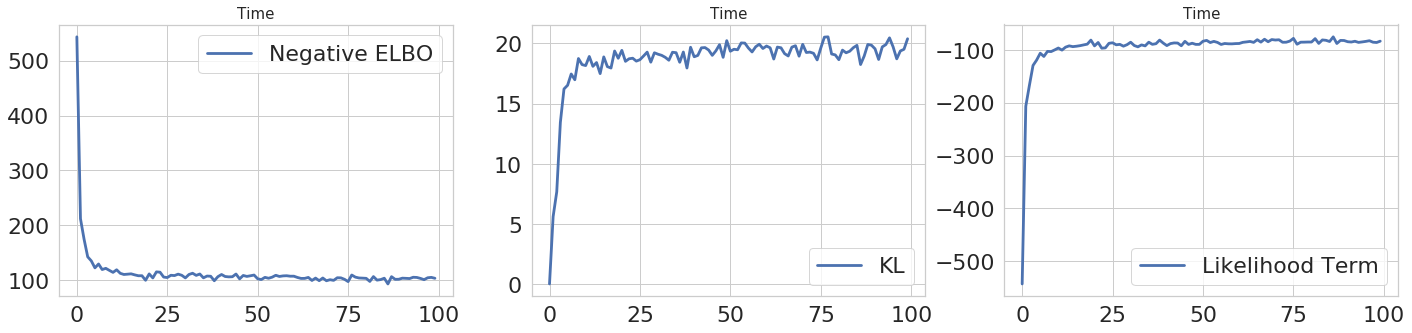

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(3*8,5))

axes[0].plot(losses, label='Negative ELBO')
axes[0].set_title('Time', fontsize=15)
axes[0].legend()

axes[1].plot(kls, label='KL')
axes[1].set_title('Time', fontsize=15)
axes[1].legend()

axes[2].plot(likelihood_terms, label='Likelihood Term')
axes[2].set_title('Time', fontsize=15)
axes[2].legend()

### Generate samples and latent interpolations

In [0]:
real_data_vals, final_samples_vals, data_reconstructions_vals = sess.run(
      [real_data, samples, reconstructions])

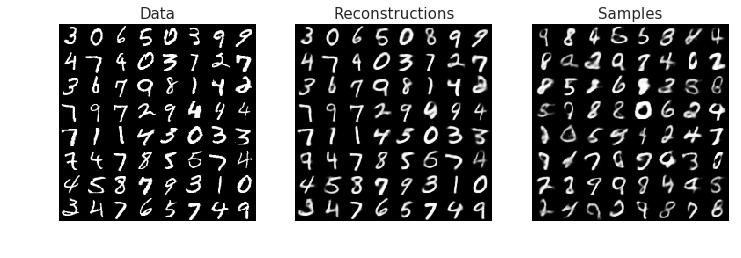

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(3*4,4))


show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], data_reconstructions_vals, 'Reconstructions')
show_digits(axes[2], final_samples_vals, 'Samples')

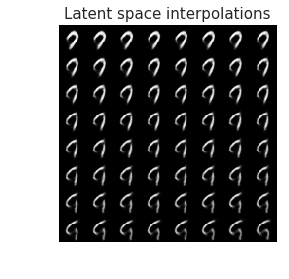

In [0]:
show_latent_interpolations(lambda x: decoder(x).mean(), prior, sess)

## Questions about amortized variational inference

* What do you observe about sample quality and reconstruction quality?
* What do you observe about the ELBO and KL term?
* Which gradient estimation method is used to compute the gradients with respect to the encoder parameters?

## Answers
 * Gap between reconstruction and sample quality due to difficulty in latent space distribution matching via KL divergence.
 * KL term goes up during training. Loss (negative elbo) goes down.
 * Reparametrization. 

# KL annealing

Objective - maximize: 
\begin{equation}
 \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x) \log p_\theta(x|z)}  - \alpha \mathbb{E}_{p^*(x)} KL(q(z|x)||p(z))
\end{equation}

Where $\alpha$ changes during training, to weigh in the KL term more.

In [0]:
tf.reset_default_graph()

In [0]:
real_data = make_tf_data_batch(mnist.train.images)
prior = make_prior()
decoder = standard_decoder

In [0]:
kl_coefficient = tf.Variable(
    tf.zeros(shape=(1), dtype=tf.float32), 
    trainable=False,
    name='kl_coeff')

kl_step = 1.0 / TRAINING_STEPS
update_kl_coeff = tf.assign(kl_coefficient, kl_coefficient + kl_step)

In [0]:
variational_posterior = encoder(real_data)# Maximize the data likelihodd and minimize the KL divergence between the prior 
# and posterior. We use the exact same loss as in the SVI case.
likelihood_term, kl_term = bound_terms(
    real_data, variational_posterior, decoder)
train_elbo = likelihood_term - kl_coefficient * kl_term
loss =  - train_elbo

In [0]:
samples = decoder(prior.sample()).mean()
samples.shape.assert_is_compatible_with([BATCH_SIZE, 28, 28, 1])

reconstructions = decoder(variational_posterior.sample()).mean()

In [0]:
# We now perform joint optimization on the encoder and decoder variables.
optimizer = tf.train.AdamOptimizer(0.001, beta1=0.9, beta2=0.9)
decoder_vars = tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=DECODER_VARIABLE_SCOPE)
encoder_vars = tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=ENCODER_VARIABLE_SCOPE)
autoencoder_vars = encoder_vars + decoder_vars
variables_update_op = optimizer.minimize(loss, var_list=autoencoder_vars)

# Ensure that a variable update is followed by an update in the KL coefficient.
with tf.control_dependencies([variables_update_op]):
  update_op = tf.identity(update_kl_coeff)

## Training

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.initialize_all_variables())

In [0]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
losses = []
kls = []
likelihood_terms = []


for i in xrange(TRAINING_STEPS):
  sess.run(update_op)
  
  
  if i % 100 == 0:
    iteration_loss, iteration_likelihood, iteration_kl  = sess.run(
          [loss, likelihood_term, kl_term])
    print('Iteration {}. Loss {}. KL {}'.format(
          i, iteration_loss, iteration_kl))
    losses.append(iteration_loss)
    kls.append(iteration_kl)
    likelihood_terms.append(iteration_likelihood)

Iteration 0. Loss [538.7282]. KL 0.0849007740617
Iteration 100. Loss [207.6383]. KL 53.8163986206
Iteration 200. Loss [163.20004]. KL 55.5619697571
Iteration 300. Loss [126.80246]. KL 67.9112243652
Iteration 400. Loss [106.59318]. KL 56.4268226624
Iteration 500. Loss [105.78894]. KL 48.3723678589
Iteration 600. Loss [95.13674]. KL 47.0271224976
Iteration 700. Loss [98.70525]. KL 43.0538406372
Iteration 800. Loss [96.5647]. KL 41.1986846924
Iteration 900. Loss [90.7644]. KL 38.3425712585
Iteration 1000. Loss [86.22786]. KL 37.3697891235
Iteration 1100. Loss [80.22088]. KL 34.7906951904
Iteration 1200. Loss [84.72531]. KL 33.7538909912
Iteration 1300. Loss [96.80273]. KL 31.1420459747
Iteration 1400. Loss [82.68167]. KL 33.0395469666
Iteration 1500. Loss [93.63019]. KL 30.8407268524
Iteration 1600. Loss [97.53325]. KL 31.0071678162
Iteration 1700. Loss [97.375435]. KL 31.1036338806
Iteration 1800. Loss [95.40447]. KL 30.0751857758
Iteration 1900. Loss [83.09582]. KL 28.6838340759
Iterati

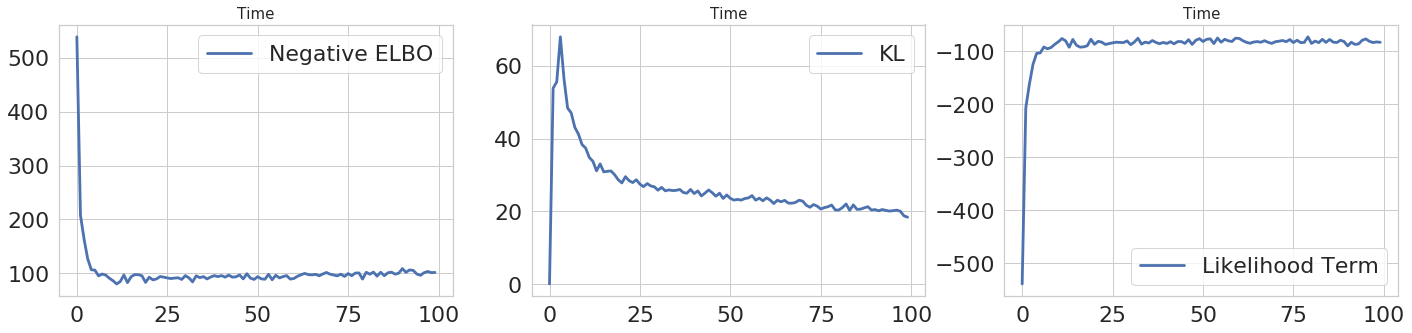

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(3*8,5))

axes[0].plot(losses, label='Negative ELBO')
axes[0].set_title('Time', fontsize=15)
axes[0].legend()

axes[1].plot(kls, label='KL')
axes[1].set_title('Time', fontsize=15)
axes[1].legend()

axes[2].plot(likelihood_terms, label='Likelihood Term')
axes[2].set_title('Time', fontsize=15)
axes[2].legend()

In [0]:
real_data_vals, final_samples_vals, data_reconstructions_vals = sess.run(
      [real_data, samples, reconstructions])

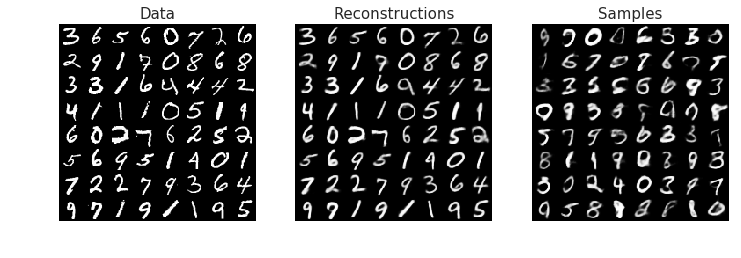

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(3*4,4))


show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], data_reconstructions_vals, 'Reconstructions')
show_digits(axes[2], final_samples_vals, 'Samples')

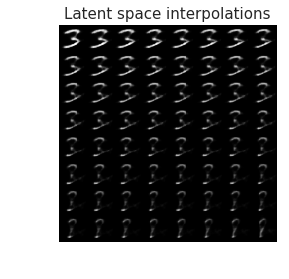

In [0]:
show_latent_interpolations(lambda x: decoder(x).mean(), prior, sess)

## Questions about KL annealing

* What do you observe about the KL behaviour throughout training as opposed to amortized variational inference without any KL annealing? 

# Constrained optimization

Instead of using KL annealing, constrained optimization can be used to automatically tune the relative weight of the likelihood and kl terms. This removes the need to manually create an optimization schedule, which can be problem specific.

The objective now becomes:

\begin{equation}
  \text{minimize } \mathbb{E}_{p^*(x)} KL(q(z|x)||p(z)) \text{ such that }  \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x) \log p_\theta(x|z)} > \alpha 
\end{equation}

This can be solved using the use of Lagrange multipliers. The objective becomes:

\begin{equation}
  \text{minimize }  \mathbb{E}_{p^*(x)} KL(q(z|x)||p(z)) + \lambda  (\mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} (\alpha - \log p_\theta(x|z)))
\end{equation}


The difference compared to the KL annealing is that:

   * $\lambda$ is a learned parameter - it will be learned using stochastic gradient descent, like the network parameters.  The difference is that the lagrangian has to solve a maximization problem. You can see this intuitively: the graadient with respect to $\lambda$ in the objective above is $\mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} (\alpha - \log p_\theta(x|z))$. If $ \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} (\alpha - \log p_\theta(x|z))> 0$, the constraint is not being satisfied, so the value of the lagrangian needs to increase. This will be done by doing gradient ascent, instead of gradient descent. Note that for $\lambda$ to be a valid lagranian in a minimization problem, it has to be positive.
   * The practicioner has to specify the hyperparameter $\alpha$, which determines the reoncstruction quality of the model.
   * the coefficient is in front of the likelihood term, not the KL term. This is mainly for convenience, as it is easier to specify the hyperparameter $\alpha$ for the likelihood (reconstruction loss).


For more assumptions made by this method, see the Karush–Kuhn–Tucker conditions.

For more information, see: 
  * http://bayesiandeeplearning.org/2018/papers/33.pdf

  If you want to use this in practice, I suggest the implementation [here](https://github.com/deepmind/sonnet/blob/master/sonnet/python/modules/optimization_constraints.py).


In [0]:
tf.reset_default_graph()

In [0]:
real_data = make_tf_data_batch(mnist.train.images)
prior = make_prior()
decoder = standard_decoder

In [0]:
# Unlike in the KL annealing case, we learn the coefficient.
# We initialize the lagrangian such that after the softplus the coefficient is 
# approximately 1.
lagrangian_var = tf.Variable(
    0.55 * tf.ones(shape=(1), dtype=tf.float32), 
    trainable=True,
    name='lagrangian')

# Ensure that the lagrangian is positive and has stable dynamics.
lagrangian = tf.nn.softplus(lagrangian_var)

In [0]:
# How good do we want the reconstruction loss to be?
# We can look at previous runs to get an idea what a reasonable value would be.
reconstruction_target = - 90

In [0]:
variational_posterior = encoder(real_data)
likelihood_term, kl_term = bound_terms(
    real_data, variational_posterior, decoder)
# Note: now the elbo is a different quanitity to what we optimize.
train_elbo = likelihood_term - kl_term
loss =  kl_term + lagrangian * (reconstruction_target - likelihood_term )

In [0]:
samples = decoder(prior.sample()).mean()
samples.shape.assert_is_compatible_with([BATCH_SIZE, 28, 28, 1])

reconstructions = decoder(variational_posterior.sample()).mean()

In [0]:
tf.trainable_variables()

[<tf.Variable 'lagrangian:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d/kernel:0' shape=(5, 5, 1, 8) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d/bias:0' shape=(8,) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_1/kernel:0' shape=(5, 5, 8, 16) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_1/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_2/kernel:0' shape=(5, 5, 16, 32) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_2/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'encoder/dense/kernel:0' shape=(1568, 10) dtype=float32_ref>,
 <tf.Variable 'encoder/dense/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'encoder/dense_1/kernel:0' shape=(1568, 10) dtype=float32_ref>,
 <tf.Variable 'encoder/dense_1/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'decoder/dense/kernel:0' shape=(10, 3136) dtype=float32_ref>,
 <tf.Variable 'decoder/dense/bias:0' shape=(3136,) dtype=float32_ref>,
 <tf.Variable 'decoder/conv2d_transpose/ke

In [0]:
lagrangian_optimizer = tf.train.GradientDescentOptimizer(0.001)

# We now perform joint optimization on the encoder and decoder variables.
optimizer = tf.train.AdamOptimizer(0.001, beta1=0.9, beta2=0.9)
decoder_vars = tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=DECODER_VARIABLE_SCOPE)
encoder_vars = tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=ENCODER_VARIABLE_SCOPE)
autoencoder_vars = encoder_vars + decoder_vars
autoencoder_variables_update_op = optimizer.minimize(
      loss, var_list=autoencoder_vars)

# Ensure that a variable update is followed by an update to the Lagrangian.
with tf.control_dependencies([autoencoder_variables_update_op]):
  # Ensure that the lagrangian solves a maximization problem instead of a
  # minimization problem by changing the sign of the loss function.
  update_op = lagrangian_optimizer.minimize(- loss, var_list=[lagrangian_var])

## Training

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.initialize_all_variables())

In [0]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
losses = []
kls = []
likelihood_terms = []
lagrangian_values = []

for i in xrange(TRAINING_STEPS):
  sess.run(update_op)
  
  
  if i % 100 == 0:
    iteration_loss, iteration_likelihood, iteration_kl, lag_val  = sess.run(
          [loss, likelihood_term, kl_term, lagrangian])
    print('Iteration {}. Loss {}. KL {}. Lagrangian {}'.format(
          i, iteration_loss, iteration_kl, lag_val))
    losses.append(iteration_loss)
    kls.append(iteration_kl)
    likelihood_terms.append(iteration_likelihood)
    lagrangian_values.append(lag_val)

Iteration 0. Loss [543.1117]. KL 0.0468898043036. Lagrangian [1.1982032]
Iteration 100. Loss [2151.1316]. KL 28.4300880432. Lagrangian [20.542797]
Iteration 200. Loss [2224.2332]. KL 39.7065124512. Lagrangian [29.597895]
Iteration 300. Loss [861.8726]. KL 58.4612426758. Lagrangian [33.975483]
Iteration 400. Loss [637.9816]. KL 58.8706054688. Lagrangian [35.98191]
Iteration 500. Loss [99.82016]. KL 60.9041404724. Lagrangian [37.12914]
Iteration 600. Loss [546.16095]. KL 52.4665489197. Lagrangian [37.918278]
Iteration 700. Loss [234.68088]. KL 55.6101303101. Lagrangian [38.35677]
Iteration 800. Loss [124.71093]. KL 57.8047180176. Lagrangian [38.650856]
Iteration 900. Loss [-89.92343]. KL 50.5216674805. Lagrangian [38.724487]
Iteration 1000. Loss [-274.25394]. KL 52.6793518066. Lagrangian [38.667652]
Iteration 1100. Loss [19.260248]. KL 49.6854743958. Lagrangian [38.596394]
Iteration 1200. Loss [-113.308655]. KL 49.5601844788. Lagrangian [38.40778]
Iteration 1300. Loss [-54.74331]. KL 49.

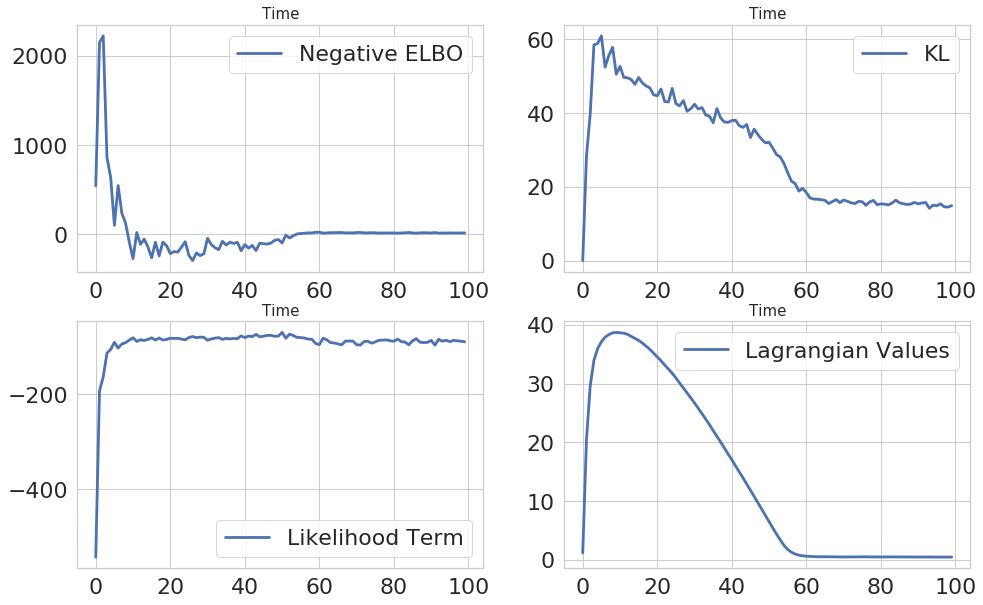

In [0]:
fig, axes = plt.subplots(2, 2, figsize=(2*8, 2* 5))

axes[0, 0].plot(losses, label='Negative ELBO')
axes[0, 0].set_title('Time', fontsize=15)
axes[0, 0].legend()

axes[0, 1].plot(kls, label='KL')
axes[0, 1].set_title('Time', fontsize=15)
axes[0, 1].legend()

axes[1, 0].plot(likelihood_terms, label='Likelihood Term')
axes[1, 0].set_title('Time', fontsize=15)
axes[1, 0].legend()

axes[1, 1].plot(lagrangian_values, label='Lagrangian Values')
axes[1, 1].set_title('Time', fontsize=15)
axes[1, 1].legend()

### Generate samples and latent interpolations

In [0]:
real_data_vals, final_samples_vals, data_reconstructions_vals = sess.run(
      [real_data, samples, reconstructions])

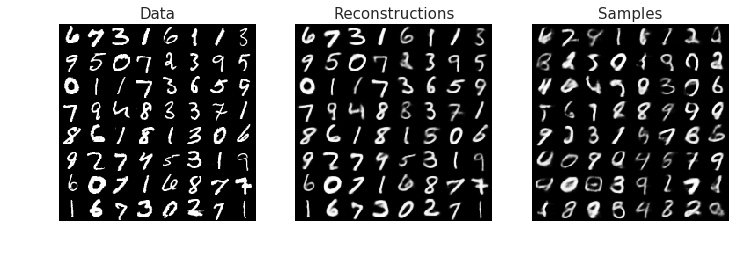

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(3*4,4))


show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], data_reconstructions_vals, 'Reconstructions')
show_digits(axes[2], final_samples_vals, 'Samples')

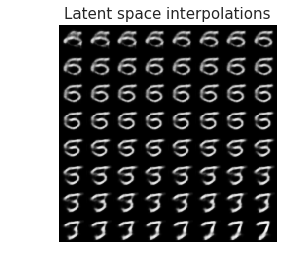

In [0]:
show_latent_interpolations(lambda x: decoder(x).mean(), prior, sess)

## Discussion about constrained optimization

* What do you observe about the behaviour of the likelihood and KL term throughout training? How is it different than in Amortized Variational inference with and without KL annealing?
* What do you notice about the behaviour of the lagrangian during training?
* How would you choose the hyperparameters of the constrained optimization problem?